In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mplfinance as mpf

pd.set_option('display.max_rows', None)

# ETH PERP data

In [2]:
import requests
import datetime

In [3]:
def rest_get_sign(url, **params):
    return requests.get(url, params=params)

def get_history_candles(symbol, start_date, end_date=None, tf=15, save_path=None):
    data = []
    
    if end_date is None:
        end_date = datetime.datetime.now()
        
    time = end_date.replace(end_date.year, end_date.month, end_date.day, end_date.hour, 0, 0, 0)
    
    print(start_date, end_date)
    
    timeframe = str(tf) + 'm' if tf < 31 else str(tf // 60) + 'H'
    while time > start_date:
        resp = rest_get_sign('https://www.okx.com/api/v5/market/history-candles', instId=symbol, bar=timeframe, after=int(time.timestamp() * 1000))
        data += resp.json()['data']
        time -= 100 * datetime.timedelta(minutes=tf)
        
    df = pd.DataFrame(data, columns=['datetime', 'open', 'high', 'low', 'close', 'volume', 'volumeCcy'])
    df = df.astype('float')
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    df['symbol'] = symbol
    df['exchange'] = 'OKX'
    df['timeframe'] = tf
    df = df.set_index('datetime', drop=True)
    
    df = df[::-1]
    
    if save_path:
        filename = f'{symbol}_{timeframe}'
        df.to_csv(f'{save_path}\\{filename}.csv')
        return df, filename
        
    return df

In [4]:
df = get_history_candles('ETH-USDT-SWAP', datetime.datetime(2022, 10, 1), tf=60)
df.head()

2022-10-01 00:00:00 2022-10-24 10:21:37.313581


,open,high,low,close,volume,volumeCcy,symbol,exchange,timeframe
datetime,,,,,,,,,
2022-09-29 07:00:00,1328.50,1330.43,1313.03,1322.00,2812362.0,281236.2,ETH-USDT-SWAP,OKX,60
2022-09-29 08:00:00,1321.99,1325.92,1314.00,1324.32,1678122.0,167812.2,ETH-USDT-SWAP,OKX,60
2022-09-29 09:00:00,1324.21,1340.42,1322.51,1336.96,2398008.0,239800.8,ETH-USDT-SWAP,OKX,60
2022-09-29 10:00:00,1336.96,1342.77,1332.50,1336.87,1160724.0,116072.4,ETH-USDT-SWAP,OKX,60
2022-09-29 11:00:00,1336.87,1346.00,1332.44,1336.68,1674661.0,167466.1,ETH-USDT-SWAP,OKX,60


## Squeeze indicator

In [5]:
length = 20
mult = 2
length_KC = 20
mult_KC = 1.5

In [6]:
def bollinger_bands(close, mult=2, lenght=20):    
    mean = close.rolling(window=lenght).mean()
    std = close.rolling(window=lenght).std(ddof=0)
    upper = mean + mult * std
    lower = mean - mult * std
    return (lower, upper)

In [7]:
def true_ranges(high, low, close):
    tr0 = abs(high - low)
    tr1 = abs(high - close.shift())
    tr2 = abs(low - close.shift())
    tr = pd.concat((tr0, tr1, tr2), axis=1).max(axis=1)
    return (tr0, tr1, tr2, tr)

In [8]:
def keltner_channel(tr, close, length=20, length_kc=20, mult_kc=1.5):
    range_ma = tr.rolling(window=length_kc).mean()
    m_avg = close.rolling(window=length).mean()
    upper = m_avg + range_ma * mult_kc
    lower = m_avg - range_ma * mult_kc
    return (lower, upper)

In [9]:
def momentum_value(high, low, close, length=20, length_kc=20):
    highest = high.rolling(window = length_kc).max()
    lowest = low.rolling(window = length_kc).min()
    
    m1 = (highest + lowest) / 2
    m_avg = close.rolling(window=length).mean()
    
    fit_y = np.array(range(0,length_kc))
    momentums = (close - (m1 + m_avg) / 2)
    momentums = momentums.rolling(window = length_kc).apply(
            lambda x : np.polyfit(fit_y, x, 1)[0] * (length_kc-1) + np.polyfit(fit_y, x, 1)[1], 
            raw=True)
    return momentums

In [10]:
def check_squeeze(lower_bb=None, upper_bb=None, lower_kc=None, upper_kc=None):
    squeeze_on = (lower_bb > lower_kc) & (upper_bb < upper_kc)
    squeeze_off = (lower_bb < lower_kc) & (upper_bb > upper_kc)
    return (squeeze_on, squeeze_off)

In [11]:
def squeeze_entry_points(squeeze_off, momentum):
    long_cond1 = (squeeze_off.shift() == False) & (squeeze_off == True) 
    long_cond2 = momentum > 0
    enter_long = long_cond1 & long_cond2
    
    short_cond1 = (squeeze_off.shift() == False) & (squeeze_off == True) 
    short_cond2 = momentum < 0
    enter_short = short_cond1 & short_cond2
    
    return (enter_long, enter_short)

In [12]:
def squeeze_exit_points(momentum):
    momentum_change = momentum - momentum.shift()
    exit_long = (momentum > 0) & (momentum_change < 0)
    exit_short = (momentum < 0) & (momentum_change > 0)
    
    return (exit_long, exit_short)

In [13]:
def squeeze_indicator(df, length_bb=20, mult_bb=2, length_kc=20, mult_kc=1.5):
    high = df['high']
    low = df['low']
    close = df['close']
    
    lower_bb, upper_bb = bollinger_bands(close, mult_bb, length_bb)
    _, _, _, tr = true_ranges(high, low, close)
    lower_kc, upper_kc = keltner_channel(tr, close, length_bb, length_kc, mult_kc)
    momentum = momentum_value(high, low, close, length_bb, length_kc)
    squeeze_on, squeeze_off = check_squeeze(lower_bb, upper_bb, lower_kc, upper_kc)
    
    enter_long, enter_short = squeeze_entry_points(squeeze_off, momentum)
    exit_long, exit_short = squeeze_exit_points(momentum)
    
    return (enter_long, enter_short, exit_long, exit_short, momentum, squeeze_off)    

In [14]:
def squeeze_history(df, **kwargs):
    enter_long, enter_short, exit_long, exit_short, momentum, squeeze_off = squeeze_indicator(df, **kwargs)
    hist = pd.DataFrame()
    hist['buy_signal'] = enter_long
    hist['sell_signal'] = enter_short
    hist['buy_exit'] = exit_long
    hist['sell_exit'] = exit_short
    hist['momentum'] = momentum
    hist['squeeze_off'] = squeeze_off
    
    return hist

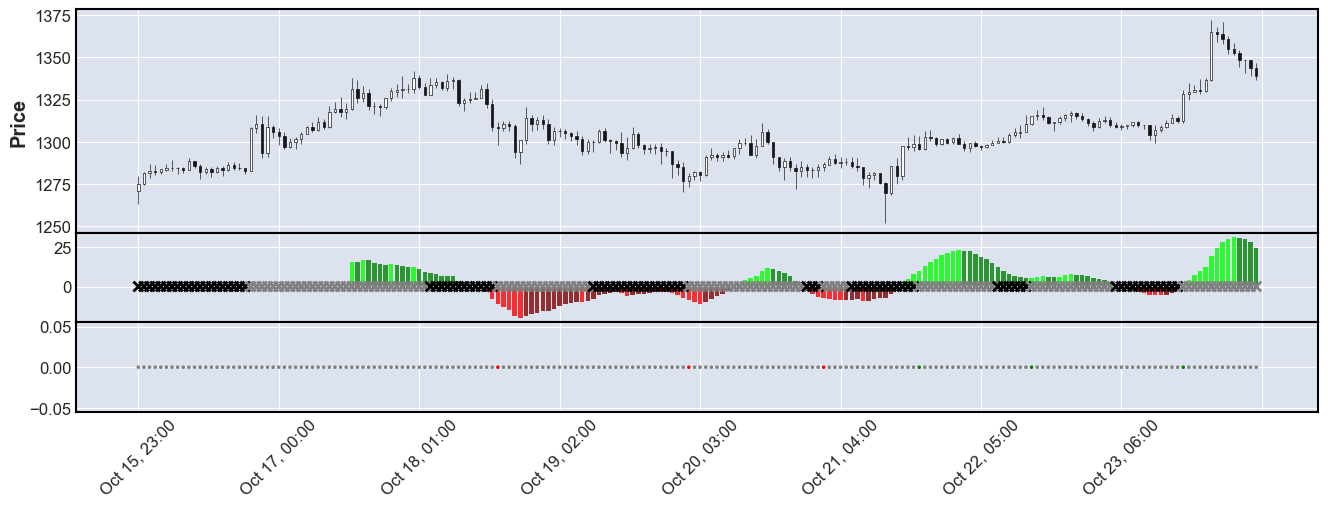

In [15]:
def plot_squeeze_example(df):

    enter_long, enter_short,exit_long, exit_short, momentum, squeeze_off = squeeze_indicator(df)

    colors = []
    for m, el, es in zip(momentum, exit_long, exit_short):
        if m >= 0:
            color = 'lime'
            if el:
                color = 'green'
        else:
            color='red'
            if es:
                color='maroon'
        colors.append(color)

    apds = [mpf.make_addplot(momentum, panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df), panel=1, type='scatter', marker='x', markersize=50, color=['gray' if s else 'black' for s in squeeze_off], secondary_y=False),
            mpf.make_addplot([0] * len(df), panel=2, type='scatter', marker='.', markersize=10, color=['green' if l else 'red' if s else 'grey' for l, s in zip(enter_long, enter_short)], secondary_y=False),
           ]
    
    
    fig, axes = mpf.plot(df, 
                  volume_panel = 3,
                  figratio=(3,1),
                  figscale=1, 
                  type='candle', 
                  addplot=apds,
                  returnfig=True)
    
plot_squeeze_example(df.tail(200))

## TuTCI

In [16]:
entr_length = 20
exit_length = 10

In [17]:
def crossover(x, y):
    return (x > y) & (x.shift() < y.shift())

In [18]:
def barssince(cond):
    ser = cond.reset_index(drop=True)
    return (ser.index - pd.Series(ser.index.where(ser)).fillna(method='ffill')).values

In [19]:
def tutci_indicator(df, entr_length=20, exit_length=10):
    high = df['high']
    low = df['low']
    
    up = high.rolling(window=entr_length).max()
    down = low.rolling(window=entr_length).min()

    sup = high.rolling(window=exit_length).max()
    sdown = low.rolling(window=exit_length).min()

    buy_signal = (high == up.shift()) | crossover(high, up.shift())
    sell_signal = (low == down.shift()) | crossover(down.shift(), low)
    buy_exit = (low == sdown.shift()) | crossover(sdown.shift(), low)
    sell_exit = (high == sup.shift()) | crossover(high, sup.shift())
    
    return (buy_signal, sell_signal, buy_exit, sell_exit, up, down, sup, sdown)

In [20]:
def tutci_history(df):
    buy_signal, sell_signal, buy_exit, sell_exit, up, down, sup, sdown = tutci_indicator(df)
    
    long_open = barssince(buy_signal) <= barssince(buy_exit)
    short_open = barssince(sell_signal) <= barssince(sell_exit)
    
    hist = pd.DataFrame()
    hist['buy_signal'] = buy_signal
    hist['sell_signal'] = sell_signal
    hist['buy_exit'] = buy_exit
    hist['sell_exit'] = sell_exit
    hist['up'] = up
    hist['down'] = down
    hist['sup'] = sup
    hist['sdown'] = sdown
    hist['long_open'] = long_open
    hist['short_open'] = short_open
    
    return hist

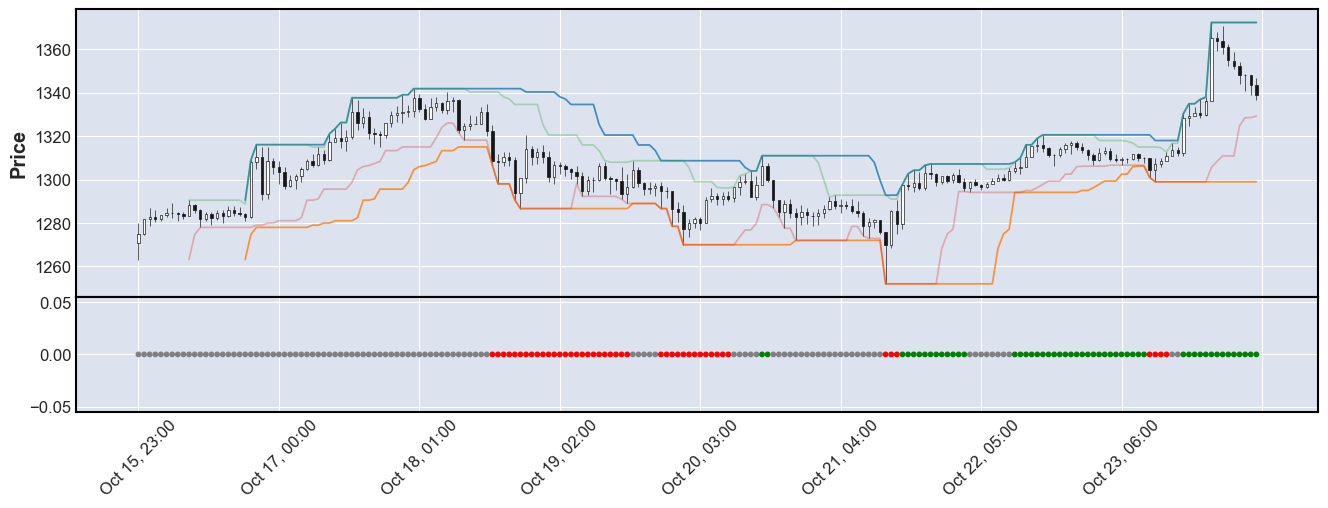

In [21]:
def plot_tutci_example(df):
    hist = tutci_history(df)
    
    apds = [mpf.make_addplot(hist[['up', 'down']], panel=0, type='line', alpha=0.8, secondary_y=False),
            mpf.make_addplot(hist[['sup', 'sdown']], panel=0, type='line', marker='.', alpha=0.3, secondary_y=False),
            mpf.make_addplot([0] * len(hist), panel=1, type='scatter', marker='o', markersize=10, 
                             color=['green' if l else 'red' if s else 'grey' for l, s in zip(hist['long_open'], hist['short_open'])], secondary_y=False),
            
            ]

    fig, axes = mpf.plot(df, 
                  volume_panel = 2,
                  figratio=(3,1),
                  figscale=1, 
                  type='candle', 
                  addplot=apds,
                  returnfig=True)

plot_tutci_example(df.tail(200))

## Tests

In [22]:
def test_function(df_test):
    long_opened = False
    short_opened = False

    long_open_price = 0
    short_open_price = 0
    
    fee_rate = 0.0005
    
    history = pd.DataFrame()

    for i in df_test.index:
        row = df_test.loc[i]
        market_price = row['close']

        order = None
        pnl = 0

        if row['buy_signal'] and not long_opened:
            long_opened = True
            long_open_price = market_price
            order = 'open long'


        if row['sell_signal'] and not short_opened:
            short_opened = True
            short_open_price = market_price
            order = 'open short'


        if row['buy_exit'] and long_opened:
            long_opened = False
            pnl = market_price - long_open_price - (market_price + long_open_price) * fee_rate
            order = 'close long'


        if row['sell_exit'] and short_opened:
            short_opened = False
            pnl = short_open_price - market_price - (market_price + short_open_price) * fee_rate
            order = 'close short'

        if order:
            upd = pd.DataFrame({
                'order': order,
                'price': market_price,
                'pnl': pnl
            }, index=[i])
            history = pd.concat((history, upd))

    history['yield'] = 1 + (history['pnl'] / history['price'].shift())
    history['cum_pnl'] = np.cumsum(history['pnl'])
    history['cum_yield'] = np.cumprod(history['yield'])
    return history

In [23]:
import math

In [24]:
# IN TEST
def test_function(df_test, balance, leverage):
    fee_rate = 0.0005
    # fee_rate = 0
    positions = []
    
    long_contracts = 0
    short_contracts = 0
    margin = 0
    borowed = 0
    last_balance = None
    
    for i in range(df_test.shape[0]):
        row = df_test.iloc[i]
        timenow = row.index # time for last closed candle
        market_price = row['close'] # add random next day price 
        high_market_price = row['high']
        low_market_price = row['low']
        order = None
         
        if leverage > 1:
            if long_contracts > 0:
                long_margin_rate = (long_contracts * low_market_price + margin) / borowed
                # print(f'long margin rate {np.round(long_margin_rate, 3)}')
            
                if long_margin_rate < 1:
                    print('LONG MARGIN CALL')
                    
            if short_contracts > 0:
                short_margin_rate =  abs(borowed) / (short_contracts * high_market_price + margin)
                print(f'short margin rate {np.round(short_margin_rate, 3)}')
            
                if short_margin_rate < 1:
                    print('SHORT MARGIN CALL')
        
        if row['buy_signal'] and long_contracts==0:
            buy_contracts = math.floor((leverage * balance ) /  market_price )
            position_notional = buy_contracts * market_price
            long_contracts += buy_contracts
            fee = position_notional * fee_rate
    
            margin = position_notional / leverage
            borowed += position_notional - margin
            balance -= margin + fee
            
            order = 'open long'
            print(f'opened {long_contracts} long, margin {np.round(margin, 3)}, mp {market_price}')
            

        if row['buy_exit'] and long_contracts > 0:
            close_long_contracts = long_contracts
            position_notional = close_long_contracts * market_price
            fee = position_notional * fee_rate
            balance += position_notional - borowed  - fee
            long_contracts = 0
            borowed = 0
            margin = 0
            
            print(f'closed {close_long_contracts} long, mp {market_price}')
            order = 'close long'
            
        if row['sell_signal'] and short_contracts == 0:
            sell_contracts = math.floor((leverage * balance ) /  market_price )
            position_notional = sell_contracts * market_price
            fee = position_notional * fee_rate
            short_contracts += sell_contracts
            margin = position_notional / leverage
            borowed += position_notional - margin
            balance -= margin + fee
            print(f'opened {short_contracts} short, margin {np.round(margin, 3)}, mp {market_price}')
            
        if row['sell_exit'] and short_contracts > 0:
            close_short_contracts = short_contracts
            position_notional = close_short_contracts * market_price
            fee = position_notional * fee_rate
            balance += position_notional - borowed - fee
            borowed = 0
            short_contracts = 0
            margin = 0
            print(f'closed {close_short_contracts} short, mp {market_price}')
        
        if last_balance != balance:
            print(f'balance {np.round(balance, 3)}, margin {np.round(margin, 3)}, borowed {np.round(borowed, 3)}, long {np.round(long_contracts, 3)}\n')
        last_balance = balance

In [34]:
def open_long(market_price, num_contracts=1, leverage=1, fee_rate=0.0005):
    position_notional = num_contracts * market_price
    fee = position_notional * fee_rate
    margin = position_notional / leverage
    long_borrowed = position_notional - margin
    return (margin, long_borrowed, position_notional, fee)

In [30]:
# SINGLE CONTRACT
# IN TEST
def test_function(df_test, balance, leverage):
    fee_rate = 0.0005
    # fee_rate = 0
    positions = []
    
    quant = 1
    
    long_contracts = 0
    short_contracts = 0
    margin = 0
    borowed = 0
    
    long_borowed = 0
    short_borowed = 0
    last_balance = None
    
    for i in range(df_test.shape[0]):
        row = df_test.iloc[i]
        timenow = row.index # time for last closed candle
        market_price = row['close'] # add random next day price 
        high_market_price = row['high']
        low_market_price = row['low']
        order = None
         
        if leverage > 1:
            if long_contracts > 0:
                long_margin_rate = (long_contracts * low_market_price + margin) / long_borowed
                # print(f'long margin rate {np.round(long_margin_rate, 3)}')
            
                if long_margin_rate < 1:
                    print('LONG MARGIN CALL')
                    
            if short_contracts > 0:
                # short_margin_rate =   (short_contracts * high_market_price + margin) / abs(borowed)
                short_margin_rate = short_borowed / (short_contracts * high_market_price - margin)
                print(f'short margin rate {np.round(short_margin_rate, 3)}')
            
                if short_margin_rate < 1:
                    print('SHORT MARGIN CALL')
        
        if row['buy_signal'] and long_contracts==0:
            buy_contracts = quant
            position_notional = buy_contracts * market_price
            long_contracts += buy_contracts
            fee = position_notional * fee_rate
    
            margin = position_notional / leverage
            long_borowed += position_notional - margin
            balance -= margin + fee
            
            order = 'open long'
            print(f'opened {long_contracts} long, margin {np.round(margin, 3)}, mp {market_price}')
            

        if row['buy_exit'] and long_contracts > 0:
            close_long_contracts = long_contracts
            position_notional = close_long_contracts * market_price
            fee = position_notional * fee_rate
            balance += position_notional - long_borowed  - fee
            long_contracts = 0
            long_borowed = 0
            margin = 0
            
            print(f'closed {close_long_contracts} long, mp {market_price}')
            order = 'close long'
            
        if row['sell_signal'] and short_contracts == 0:
            sell_contracts = quant
            position_notional = sell_contracts * market_price
            fee = position_notional * fee_rate
            short_contracts += sell_contracts
            margin = position_notional / leverage
            # borowed -= position_notional + margin
            short_borowed = position_notional + margin
            balance -= margin + fee
            print(f'opened {short_contracts} short, margin {np.round(margin, 3)}, mp {market_price}')
            
        if row['sell_exit'] and short_contracts > 0:
            close_short_contracts = short_contracts
            position_notional = close_short_contracts * market_price
            fee = position_notional * fee_rate
            balance += - position_notional + short_borowed - fee
            short_borowed = 0
            short_contracts = 0
            margin = 0
            print(f'closed {close_short_contracts} short, mp {market_price}')
        
        if last_balance != balance:
            print(f'balance {np.round(balance, 3)}, margin {np.round(margin, 3)}, borowed {np.round(borowed, 3)}, long {np.round(long_contracts, 3)}, short {np.round(short_contracts, 3)}\n')
        last_balance = balance

In [33]:
test_tutci(df, balance=10000, leverage=3)

balance 10000, margin 0, borowed 0, long 0, short 0

opened 1 short, margin 442.54, mp 1327.62
balance 9556.796, margin 442.54, borowed 0, long 0, short 1

short margin rate 1.979
short margin rate 1.92
opened 1 long, margin 453.32, mp 1359.96
closed 1 short, mp 1359.96
balance 9512.316, margin 0, borowed 0, long 1, short 0

closed 1 long, mp 1325.33
balance 9930.344, margin 0, borowed 0, long 0, short 0

opened 1 short, margin 437.133, mp 1311.4
balance 9492.555, margin 437.133, borowed 0, long 0, short 1

short margin rate 1.99
short margin rate 1.986
short margin rate 1.985
short margin rate 1.995
short margin rate 1.991
short margin rate 1.989
short margin rate 1.993
short margin rate 1.989
short margin rate 1.999
short margin rate 1.997
short margin rate 1.997
short margin rate 1.996
short margin rate 1.986
short margin rate 1.986
closed 1 short, mp 1312.31
balance 9928.122, margin 0, borowed 0, long 0, short 0

opened 1 short, margin 429.92, mp 1289.76
balance 9497.557, margin 42

In [226]:
test_tutci(df)#, balance=10000, leverage=3)

,order,price,pnl,yield,cum_pnl,cum_yield
2022-09-30 14:00:00,open long,1359.96,0.000000,NaN,0.000000,NaN
2022-10-01 11:00:00,close long,1325.33,-35.972645,0.973549,-35.972645,0.973549
2022-10-01 16:00:00,open short,1311.40,0.000000,1.000000,-35.972645,0.973549
2022-10-02 06:00:00,close short,1312.31,-2.221855,0.998306,-38.194500,0.971899
2022-10-02 10:00:00,open short,1289.76,0.000000,1.000000,-38.194500,0.971899
2022-10-02 19:00:00,close short,1304.91,-16.447335,0.987248,-54.641835,0.959505
2022-10-02 23:00:00,open short,1276.77,0.000000,1.000000,-54.641835,0.959505
2022-10-03 12:00:00,close short,1301.83,-26.349300,0.979363,-80.991135,0.939704
2022-10-03 14:00:00,open long,1319.67,0.000000,1.000000,-80.991135,0.939704
2022-10-05 08:00:00,close long,1344.48,23.477925,1.017791,-57.513210,0.956422


### TuTCI only

In [27]:
def test_tutci(data, **kwargs):
    tutci = tutci_history(data)
    df_test = pd.concat((data, tutci[['buy_signal', 'sell_signal', 'buy_exit', 'sell_exit']]), axis=1)
    
    return test_function(df_test, **kwargs)

### TuTCI enter, exit squeeze

In [28]:
def test_tutci_squeeze(data):
    tutci = tutci_history(data)
    squeeze = squeeze_history(data)
    df_test = pd.concat((data, tutci[['buy_signal', 'sell_signal']], squeeze[['buy_exit', 'sell_exit']]), axis=1)
    
    return test_function(df_test)

### Test from 'market_data' folder. Saves results to 'results' folder.

In [51]:
import os

In [64]:
data_folder = 'market_data'
save_folder = 'results'

start_date = datetime.datetime(2022, 10, 10)
end_date = None
timeframes = [60]
symbols = ['ETH-USDT-SWAP']

if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
print(f'Testing: {os.listdir(data_folder)}')

for test_name, test in {'tutci':test_tutci, 'tutci_squeeze':test_tutci_squeeze}.items():
    for tf in timeframes:
        for symbol in symbols:
            
            data, filename = get_history_candles(symbol, start_date, end_date, tf, save_path=data_folder)
            df_res = test(data)
            
            print(f'total pnl: {df_res["cum_pnl"].tail(1)}')
            df_res.to_csv(f'{save_folder}\\{test_name}_{filename}.csv', index_label='datetime')        

Testing: []
2022-10-10 00:00:00 2022-10-20 15:49:44.453433
total pnl: 2022-10-20 09:00:00    17.15293
Name: cum_pnl, dtype: float64
2022-10-10 00:00:00 2022-10-20 15:49:45.920488
total pnl: 2022-10-20 04:00:00    0.66277
Name: cum_pnl, dtype: float64
